In [43]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
                             balanced_accuracy_score, precision_score, recall_score, 
                             confusion_matrix, ConfusionMatrixDisplay, roc_auc_score,
                             average_precision_score)

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier


## Labeling Function

In [2]:
# load the metadata
metadata = pd.read_csv("metadata.csv")

# load the annotations
annotations_df = pd.read_csv("annotations.csv")
annotations_embeddings = np.load("annotations_text_embeddings.npz")["embeddings"]
  
# load audio features
feature_filename = metadata.loc[0, "filename"].replace("mp3", "npz")
features = np.load(os.path.join("audio_features", feature_filename))
print(list(features.keys()))
print("Shape of ZCR feature (time, n_features)", features["zerocrossingrate"].shape)
print("Shape of MFCC features (time, n_features)", features["mfcc"].shape)
  
# load audio (optional, just i you want to compute your own features ...)
import librosa
waveform, sr = librosa.load(os.path.join("audio", metadata.loc[0, "filename"]), sr=16000)

# load labels
filename = os.path.join("labels", "14_labels.npz")
labels = np.load(filename)
print("Classes:", list(labels.keys()))
print("Bird Chirp Labels:", labels["Bird Chirp"].mean(-1))

['embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2', 'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth', 'contrast', 'zerocrossingrate']
Shape of ZCR feature (time, n_features) (184, 1)
Shape of MFCC features (time, n_features) (184, 32)
Classes: ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']
Bird Chirp Labels: [0. 0. 0. 0. 0. 0. 0. 0. 

In [3]:
# choose audio 14
filename = metadata.loc[0, "filename"]
waveform, sr = librosa.load(os.path.join("audio", filename), sr=16000)

In [4]:
# check the free text annot. for audio 14
clip_annotations = annotations_df[annotations_df["filename"] == filename]
display(clip_annotations[["onset", "offset", "text"]])

,onset,offset,text
16550,0.038424,21.978526,People are speaking.


In [5]:
filename = os.path.join("labels", "789155_labels.npz")
labels = np.load(filename)
print("Classes:", list(labels.keys()))
print("Rain:", labels["Rain"].mean(-1))

Classes: ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']
Rain: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

In [6]:
def viz_annot(audio_filename, label_name, metadata_df, annotations_df):
    audio_path = os.path.join("audio", audio_filename)
    waveform, sr = librosa.load(audio_path, sr=16000)
    time = np.linspace(0, len(waveform) / sr, num=len(waveform))
    label_filename = audio_filename.replace(".mp3", "_labels.npz")
    label_path = os.path.join("labels", label_filename)
    labels = np.load(label_path)
    label_activity = labels[label_name].mean(axis=-1)

    relevant_annotations = annotations_df[annotations_df['filename'] == audio_filename]

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(time, waveform)
    plt.title(f"Waveform: {audio_filename}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.subplot(2, 1, 2)
    plt.plot(np.linspace(0, len(label_activity) * (len(waveform) / sr) / len(label_activity), len(label_activity)), label_activity, label='Label Activity')
    plt.yticks([0, 1], ['Inactive', 'Active'])
    plt.ylabel(label_name)
    plt.xlabel("Time (s)")

    if 'onset' in relevant_annotations.columns and 'offset' in relevant_annotations.columns and 'annotation' in relevant_annotations.columns:
        for index, row in relevant_annotations.iterrows():
            start = row['onset']
            end = row['offset']
            annotation_text = row['annotation']
            plt.axvspan(start, end, color='red', alpha=0.2, label='Annotation Region' if index == 0 else "")
            plt.text((start + end) / 2, 0.8, annotation_text, ha='center', va='center', color='red')

    plt.tight_layout()
    plt.legend()
    plt.show()

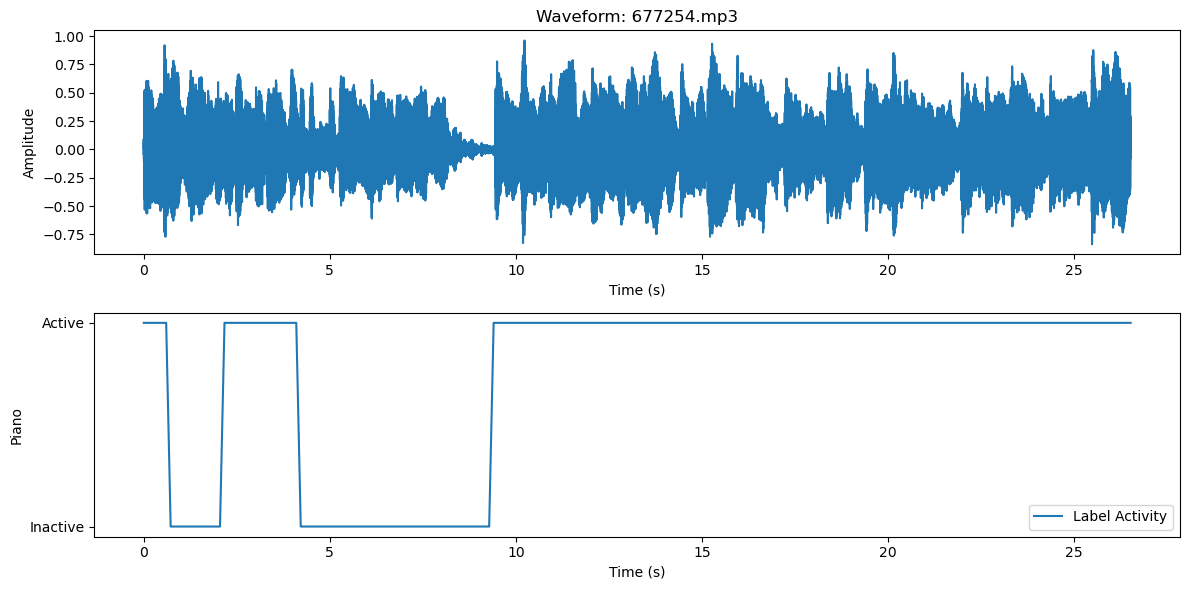

In [7]:
filename = metadata.loc[24, "filename"]
label_to_inspect = "Piano"
viz_annot(filename, label_to_inspect, metadata, annotations_df)
ipd.Audio(os.path.join("audio", filename))

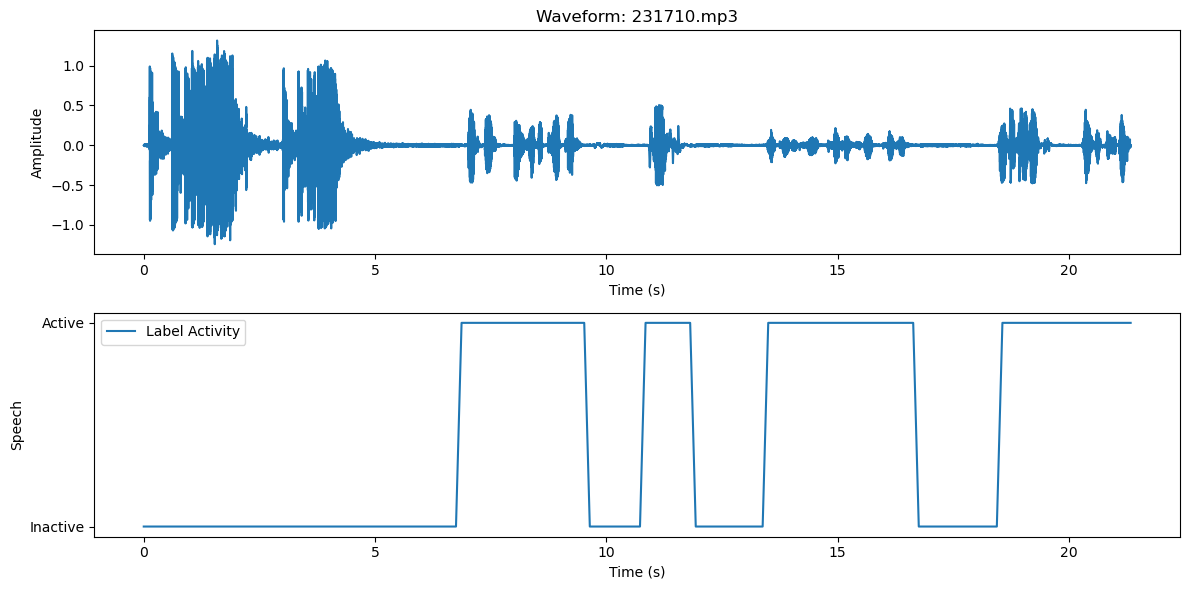

In [8]:
sample_filename = metadata.loc[17, "filename"]
label_to_inspect = "Speech"
viz_annot(sample_filename, label_to_inspect, metadata, annotations_df)
ipd.Audio(os.path.join("audio", sample_filename))

In [9]:
filename = os.path.join("labels", "677254_labels.npz")
labels = np.load(filename)
print("Classes:", list(labels.keys()))
print("Piano Labels:", labels["Piano"].mean(-1))

Classes: ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']
Piano Labels: [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1

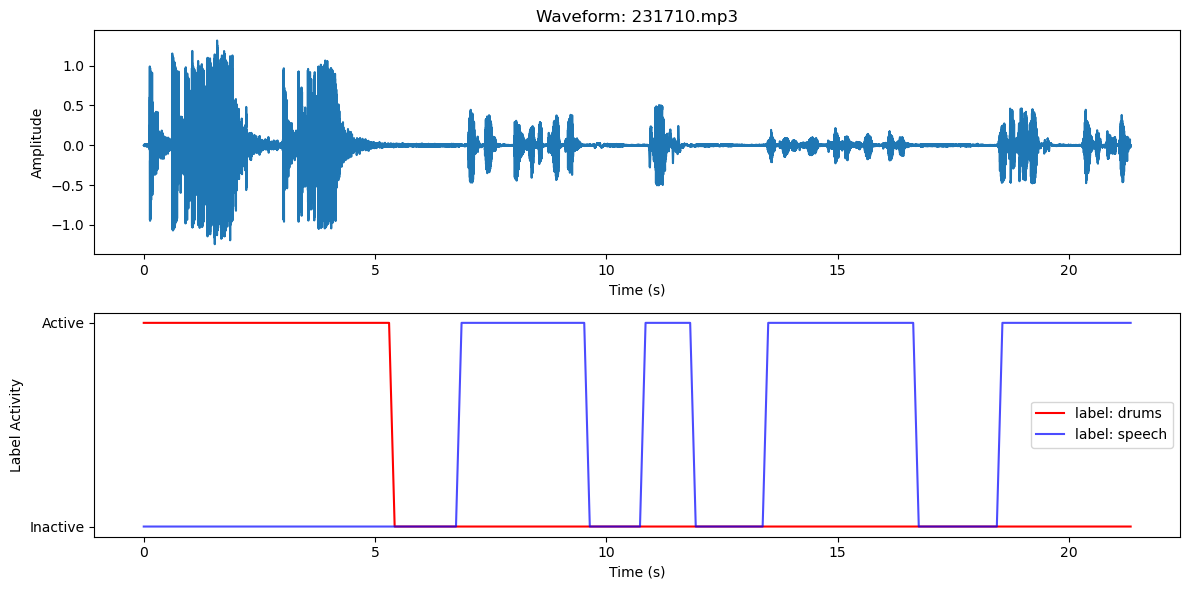

In [10]:
def viz_annot(audio_filename, label_name, metadata_df, annotations_df):
    audio_path = os.path.join("audio", audio_filename)
    waveform, sr = librosa.load(audio_path, sr=16000)
    time = np.linspace(0, len(waveform) / sr, num=len(waveform))

    label_filename = audio_filename.replace(".mp3", "_labels.npz")
    label_path = os.path.join("labels", label_filename)
    labels = np.load(label_path)
    label_activity = labels[label_name].mean(axis=-1)
    speech_activity = labels["Speech"].mean(axis=-1)
    relevant_annotations = annotations_df[annotations_df['filename'] == audio_filename]

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, waveform)
    plt.title(f"Waveform: {audio_filename}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.subplot(2, 1, 2)
    plt.plot(np.linspace(0, len(label_activity) * (len(waveform) / sr) / len(label_activity), len(label_activity)), label_activity, label='label: drums', color='red')
    plt.plot(np.linspace(0, len(speech_activity) * (len(waveform) / sr) / len(speech_activity), len(speech_activity)), speech_activity, label='label: speech', color='blue', alpha=0.7)

    plt.yticks([0, 1], ['Inactive', 'Active'])
    plt.ylabel("Label Activity")
    plt.xlabel("Time (s)")

    if 'onset' in relevant_annotations.columns and 'offset' in relevant_annotations.columns and 'annotation' in relevant_annotations.columns:
        for index, row in relevant_annotations.iterrows():
            start = row['onset']
            end = row['offset']
            annotation_text = row['annotation']
            plt.axvspan(start, end, color='red', alpha=0.2, label='Annotation Region' if index == 0 else "")
            plt.text((start + end) / 2, 0.8, annotation_text, ha='center', va='center', color='red')

    plt.tight_layout()
    plt.legend()
    plt.show()

filename = metadata.loc[17, "filename"]
label_to_inspect = "Drums"
viz_annot(filename, label_to_inspect, metadata, annotations_df)
ipd.Audio(os.path.join("audio", filename))


In [11]:
train_files = metadata["filename"]
features_dir = 'audio_features'
labels_dir = 'labels'
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

In [12]:
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

def read_files(file_names, num_to_read=1000):
    X_train = []
    Y_train = {}
    for c in categories:
        Y_train[c] = []
    for f in file_names[:num_to_read]: #we are not loading the entire dataset due to processing time
        if not os.path.exists(os.path.join(features_dir , f.split('.')[0] + '.npz')):
            continue
        features = np.load(os.path.join(features_dir , f.split('.')[0] + '.npz'))["embeddings"]
        X_train.append(features)
        y = np.load(os.path.join(labels_dir , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y)))
    X_train = np.concatenate(X_train)
    return X_train, Y_train


In [13]:
X_train, Y_train = read_files(train_files, 500)

## Baseline Classifier

In [14]:
class Baseline_classifier():

    def __init__(self):
        self.majority_class = None

    def fit(self, x_train, y_train):
        '''x_train is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        y_train is a list of binary labels in the shape Nx1
        '''
        self.majority_class =  1 if sum(y_train) > len(y_train) / 2 else 0

    def predict(self, x):
        '''x is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        The function should return the predicted binary labels as a numpy array of shape Nx1
        '''
        predictions = np.zeros(x.shape[0]) + self.majority_class
        return predictions

In [15]:
piano_x, piano_y = X_train, np.array(Y_train['Piano'])

In [16]:
baseline = Baseline_classifier()
baseline.fit(piano_x, piano_y)

y_train_pred = baseline.predict(piano_x)

train_fraction_correct = np.mean(y_train_pred == piano_y)

print(f"Training Fraction Correct: {train_fraction_correct:.2f}")

Training Fraction Correct: 1.00


In [17]:
# Plotting function
def plot_decision_boundary(knn, X, y, title, highlight_point=None):
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5, 3))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=100, label='Train data')
    if highlight_point is not None:
        plt.scatter(highlight_point[0][0], highlight_point[0][1], color='gold', edgecolor='k',
                    marker='*', s=250, label='Test point (not in train)')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

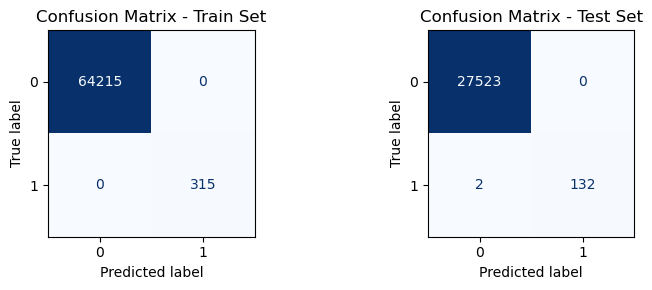

In [18]:
# Split data
X_train_piano, X_test_piano, y_train_piano, y_test_piano = train_test_split(
    piano_x, piano_y, test_size=0.3, random_state=42
)

# Train model
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_piano, y_train_piano)

# Predictions
y_train_pred = knn.predict(X_train_piano)
y_test_pred = knn.predict(X_test_piano)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Side by side, smaller overall size

# Train confusion matrix
cm_train = confusion_matrix(y_train_piano, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=knn.classes_)
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train Set")

# Test confusion matrix
cm_test = confusion_matrix(y_test_piano, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=knn.classes_)
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test Set")

plt.tight_layout()
plt.show()

## K-nearest Neighbors Classifier

In [28]:
train_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[:int(len(metadata)*0.8)]
test_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata)*0.8):]

X_train, Y_train = read_files(train_files, 500)
X_test, Y_test = read_files(test_files, 100)

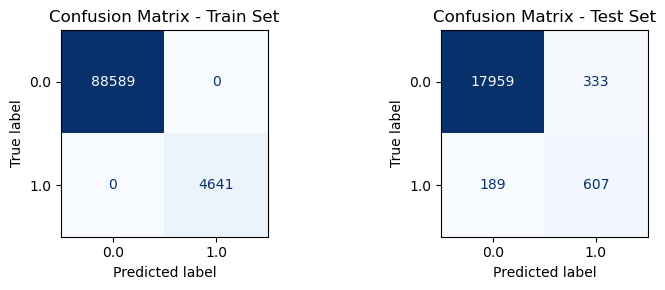

In [29]:
piano_x_train, piano_y_train = X_train, np.array(Y_train['Piano'])
piano_x_test, piano_y_test = X_test, np.array(Y_test['Piano'])

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(piano_x_train, piano_y_train)

y_train_pred = knn.predict(piano_x_train)
y_test_pred = knn.predict(piano_x_test)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Side by side, smaller overall size

# Train confusion matrix
cm_train = confusion_matrix(piano_y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=knn.classes_)
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - Train Set")

# Test confusion matrix
cm_test = confusion_matrix(piano_y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=knn.classes_)
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - Test Set")

plt.tight_layout()
plt.show()

In [30]:
# train 70%, validation 20%, test 10%

train_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[:int(len(metadata)*0.7)]
validation_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata)*0.7):int(len(metadata)*0.9)]
test_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()[int(len(metadata)*0.9):]

### Metrics

In [31]:
# y_true: ground truth labels
# y_pred: predicted class labels (e.g., 0 or 1)
# y_scores: predicted probabilities or decision function scores

accuracy      = accuracy_score(piano_y_test, y_test_pred)
precision     = precision_score(piano_y_test, y_test_pred, zero_division=0)
recall        = recall_score(piano_y_test, y_test_pred)
f1            = f1_score(piano_y_test, y_test_pred)
roc_auc       = roc_auc_score(piano_y_test, y_test_pred)
pr_auc        = average_precision_score(piano_y_test, y_test_pred)
weighted_acc  = balanced_accuracy_score(piano_y_test, y_test_pred)

print(f"Accuracy:         {accuracy:.3f}")
print(f"Weighted Accuracy:{weighted_acc:.3f}")
print(f"Precision:        {precision:.3f}")
print(f"Recall:           {recall:.3f}")
print(f"F1 Score:         {f1:.3f}")
print(f"ROC AUC:          {roc_auc:.3f}")
print(f"PR AUC:           {pr_auc:.3f}")

Accuracy:         0.973
Weighted Accuracy:0.872
Precision:        0.646
Recall:           0.763
F1 Score:         0.699
ROC AUC:          0.872
PR AUC:           0.502


In [32]:
X_train, Y_train = read_files(train_files, 500)
X_test, Y_test = read_files(test_files, 50)
X_val, Y_val = read_files(validation_files, 100)

#subsampling the training data to reduce run time
sample_size = 1000
indices = np.random.choice(len(X_train), size=sample_size, replace=False)

X_train = X_train[indices]
for c in categories:
    Y_train[c] = [Y_train[c][i] for i in indices]

piano_x_train, piano_y_train = X_train, np.array(Y_train['Piano'])
piano_x_test, piano_y_test = X_test, np.array(Y_test['Piano'])
piano_x_val, piano_y_val = X_val, np.array(Y_val['Piano'])

## Decision Tree Classifier

In [33]:
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

best_score = 0
best_params = None
best_model = None

# Generate all combinations of hyperparameters
for max_depth, min_samples_split, criterion in itertools.product(
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['criterion']
):
    model = DecisionTreeClassifier(max_depth=max_depth,min_samples_split=min_samples_split,criterion=criterion,random_state=42)
    model.fit(piano_x_train, piano_y_train)

    y_val_pred = model.predict(piano_x_val)
    score = balanced_accuracy_score(piano_y_val, y_val_pred)
    print(f"Params: max_depth={max_depth}, min_samples_split={min_samples_split}, criterion={criterion} --> Accuracy: {score:.4f}")

    if score > best_score:
        best_score = score
        best_params = {
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'criterion': criterion
        }
        best_model = model
print("\nBest Parameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_score:.4f}")

Params: max_depth=3, min_samples_split=2, criterion=gini --> Accuracy: 0.9671
Params: max_depth=3, min_samples_split=2, criterion=entropy --> Accuracy: 0.7647
Params: max_depth=3, min_samples_split=5, criterion=gini --> Accuracy: 0.9671
Params: max_depth=3, min_samples_split=5, criterion=entropy --> Accuracy: 0.7647
Params: max_depth=3, min_samples_split=10, criterion=gini --> Accuracy: 0.9659
Params: max_depth=3, min_samples_split=10, criterion=entropy --> Accuracy: 0.7647
Params: max_depth=5, min_samples_split=2, criterion=gini --> Accuracy: 0.9733
Params: max_depth=5, min_samples_split=2, criterion=entropy --> Accuracy: 0.7637
Params: max_depth=5, min_samples_split=5, criterion=gini --> Accuracy: 0.9733
Params: max_depth=5, min_samples_split=5, criterion=entropy --> Accuracy: 0.7637
Params: max_depth=5, min_samples_split=10, criterion=gini --> Accuracy: 0.8536
Params: max_depth=5, min_samples_split=10, criterion=entropy --> Accuracy: 0.8998
Params: max_depth=10, min_samples_split=2,

In [56]:
selected_classes = {'Saxophone', 'Piano'}

y_train = np.array([Y_train[cls] for cls in selected_classes]).T
y_val = np.array([Y_val[cls] for cls in selected_classes]).T
y_test = np.array([Y_test[cls] for cls in selected_classes]).T

In [60]:
n_labels = y_val.shape[1]
balanced_accuracies = []

for i in range(n_labels):
    score = balanced_accuracy_score(y_val[:, i], Y_pred[:, i])
    balanced_accuracies.append(score)

# Macro-average across labels
balanced_accuracy_macro = np.mean(balanced_accuracies)

print("Macro-Averaged Balanced Accuracy:", balanced_accuracy_macro)

Macro-Averaged Balanced Accuracy: 0.5821799307958477


## Random Forest Classifier with Multi-Label Classification

In [61]:
X = X_train
Y = y_train

base_clf = RandomForestClassifier()

br_clf = MultiOutputClassifier(base_clf)

br_clf.fit(X, Y)

Y_pred = br_clf.predict(X_val)

n_labels = y_val.shape[1]
balanced_accuracies = []

for i in range(n_labels):
    score = balanced_accuracy_score(y_val[:, i], Y_pred[:, i])
    balanced_accuracies.append(score)

balanced_accuracy_macro = np.mean(balanced_accuracies)

print("Macro-Averaged Balanced Accuracy:", balanced_accuracy_macro)

Macro-Averaged Balanced Accuracy: 0.5751779184431531


In [62]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

best_score = 0
best_params = None
best_model = None

for n_estimators, max_depth, min_samples_split, criterion in itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['criterion']
):
    
    base_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )
    
    clf = MultiOutputClassifier(base_clf)
    clf.fit(X, Y)  # X = X_train, Y = y_train (for Saxophone and Piano)
    Y_pred_val = clf.predict(X_val)
    
    
    balanced_accuracies = [
        balanced_accuracy_score(y_val[:, i], Y_pred_val[:, i])
        for i in range(y_val.shape[1])
    ]
    
    score = np.mean(balanced_accuracies)
    
    print(f"Params: n_estimators={n_estimators}, max_depth={max_depth}, "
          f"min_samples_split={min_samples_split}, criterion={criterion} --> "
          f"Macro Balanced Accuracy: {score:.4f}")

    if score > best_score:
        best_score = score
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'criterion': criterion
        }
        best_model = clf

print("\nBest Parameters:")
print(best_params)
print(f"Best Validation Macro Balanced Accuracy: {best_score:.4f}")

Params: n_estimators=50, max_depth=5, min_samples_split=2, criterion=gini --> Macro Balanced Accuracy: 0.5969
Params: n_estimators=50, max_depth=5, min_samples_split=2, criterion=entropy --> Macro Balanced Accuracy: 0.6273
Params: n_estimators=50, max_depth=5, min_samples_split=5, criterion=gini --> Macro Balanced Accuracy: 0.5813
Params: n_estimators=50, max_depth=5, min_samples_split=5, criterion=entropy --> Macro Balanced Accuracy: 0.6420
Params: n_estimators=50, max_depth=10, min_samples_split=2, criterion=gini --> Macro Balanced Accuracy: 0.6324
Params: n_estimators=50, max_depth=10, min_samples_split=2, criterion=entropy --> Macro Balanced Accuracy: 0.6071
Params: n_estimators=50, max_depth=10, min_samples_split=5, criterion=gini --> Macro Balanced Accuracy: 0.6790
Params: n_estimators=50, max_depth=10, min_samples_split=5, criterion=entropy --> Macro Balanced Accuracy: 0.6276
Params: n_estimators=50, max_depth=None, min_samples_split=2, criterion=gini --> Macro Balanced Accuracy

## Analyzing Predictions

In [68]:
all_files = set(metadata["filename"])
train_files_set = set(train_files)
unused_files = all_files - train_files_set
print("Unused files:", unused_files)

Unused files: {'332419.mp3', '406542.mp3', '336600.mp3', '424876.mp3', '432553.mp3', '251646.mp3', '556370.mp3', '626959.mp3', '721648.mp3', '642775.mp3', '622447.mp3', '755202.mp3', '336342.mp3', '592403.mp3', '406545.mp3', '390444.mp3', '157205.mp3', '269782.mp3', '339307.mp3', '166260.mp3', '577458.mp3', '157164.mp3', '591188.mp3', '106484.mp3', '623189.mp3', '462494.mp3', '165290.mp3', '353176.mp3', '330142.mp3', '736635.mp3', '61089.mp3', '464728.mp3', '26017.mp3', '34287.mp3', '216368.mp3', '467419.mp3', '271451.mp3', '724840.mp3', '424909.mp3', '143964.mp3', '91761.mp3', '418917.mp3', '342642.mp3', '670308.mp3', '721008.mp3', '559756.mp3', '748576.mp3', '623051.mp3', '210716.mp3', '672736.mp3', '244609.mp3', '376784.mp3', '460899.mp3', '785393.mp3', '21322.mp3', '512685.mp3', '451625.mp3', '542742.mp3', '274594.mp3', '136599.mp3', '690473.mp3', '78787.mp3', '416268.mp3', '105117.mp3', '588178.mp3', '106289.mp3', '108668.mp3', '514312.mp3', '721300.mp3', '18038.mp3', '329548.mp3'

In [77]:
def evaluate_audio(file, label_name, model, features_dir, labels_dir):
    audio_path = os.path.join("audio", file)
    waveform, sr = librosa.load(audio_path, sr=16000)
    time = np.linspace(0, len(waveform) / sr, num=len(waveform))
    
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram: {file}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    
    feature_file = os.path.join(features_dir, file.replace(".mp3", ".npz"))
    label_file = os.path.join(labels_dir, file.replace(".mp3", "_labels.npz"))
    features = np.load(feature_file)["embeddings"]
    labels = np.load(label_file)
    label_activity = labels[label_name].mean(axis=-1)
    
    predictions = model.predict(features)
    
    plt.subplot(2, 1, 2)
    plt.plot(np.linspace(0, len(label_activity) * (len(waveform) / sr) / len(label_activity), len(label_activity)), label_activity, label='Ground Truth', color='blue')
    plt.plot(np.linspace(0, len(predictions) * (len(waveform) / sr) / len(predictions), len(predictions)), predictions, label='Predictions', color='red', alpha=0.7)
    plt.yticks([0, 1], ['Inactive', 'Active'])
    plt.ylabel(label_name)
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return ipd.Audio(audio_path)

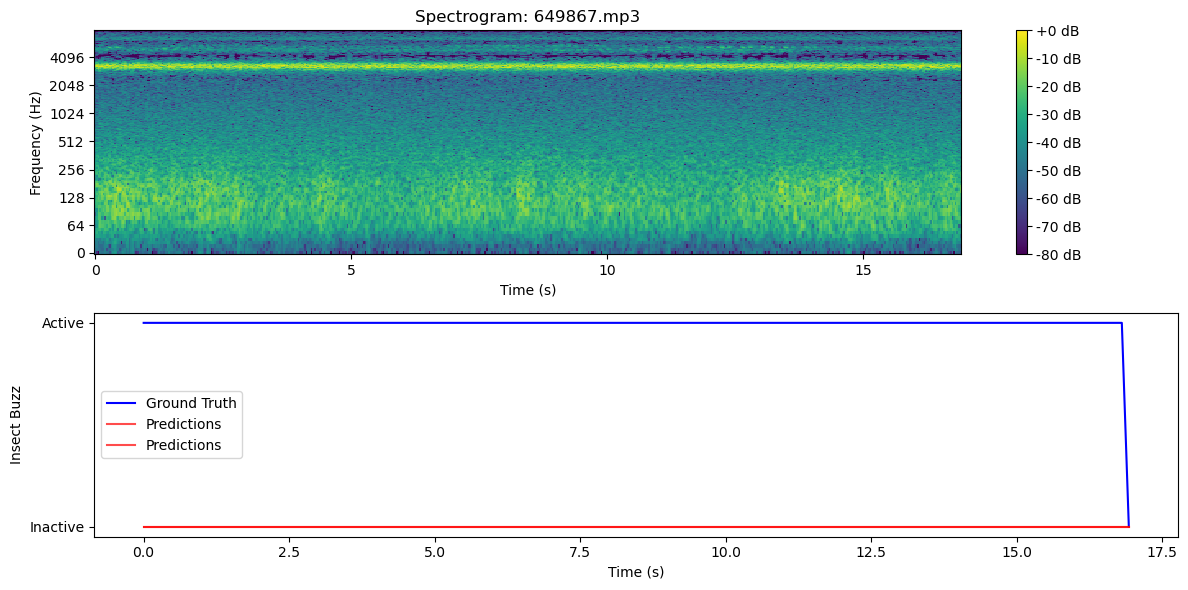

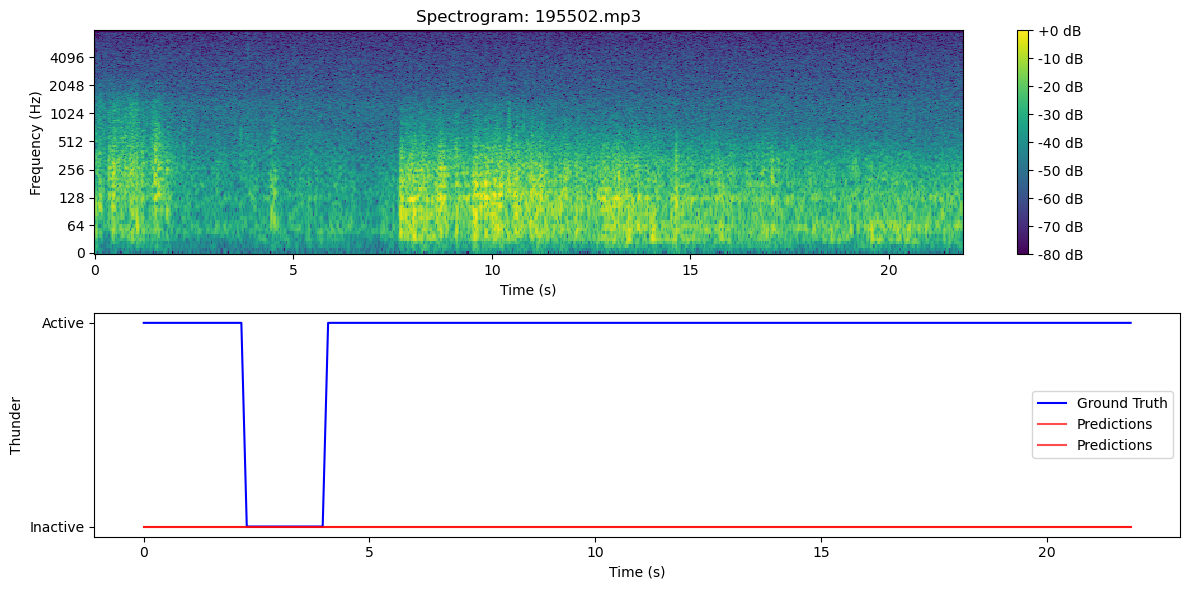

In [78]:
file1 = '649867.mp3'
label1 = "Insect Buzz"
audio1 = evaluate_audio(file1, label1, best_model, features_dir, labels_dir)
display(audio1)

file2 = '195502.mp3'
label2 = "Thunder"
audio2 = evaluate_audio(file2, label2, best_model, features_dir, labels_dir)
display(audio2)